In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import gc
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from math import sqrt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import gc
from keras.models import Model
from keras.layers import Dense, Conv1D, Dropout, Input, GlobalAveragePooling1D, MaxPool1D, Flatten

In [13]:
questions = pd.read_csv('./train.csv')
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [14]:
questions.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [15]:
questions['lengths'] = questions.question_text.apply(len)

In [16]:
round(questions.target.value_counts()[1]*100/(questions.target.value_counts()[1] + questions.target.value_counts()[0]),2)

6.19

### Hypothesis - Slightly longer texts are insincere

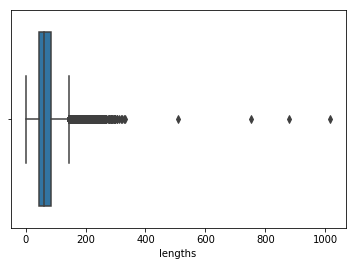

In [17]:
sns.boxplot(questions.lengths)

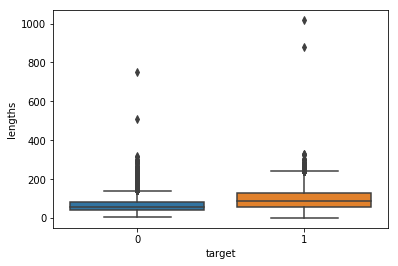

In [18]:
sns.boxplot(data=questions, x = 'target', y = 'lengths')

In [19]:
questions[['target','lengths']].groupby('target').median()

,lengths
target,
0,59
1,86


In [20]:
# max_len = max(questions.lengths)
max_len = 200

### Embeddings

In [21]:
embeddings = dict()
file = open('./glove.840B.300d/glove.840B.300d.txt', encoding='UTF-8')
for line in file:
    values = line.split(" ")
    word, coefs  = values[0], np.array(values[1:], dtype='float32')
    embeddings[word] = coefs

In [22]:
tkn = Tokenizer()
tkn.fit_on_texts(questions.question_text)
vocab_size = len(tkn.word_index) + 1
enc_sentence = tkn.texts_to_sequences(questions.question_text)
enc_sentence = pad_sequences(enc_sentence, max_len)

In [23]:
embed_matrix = np.zeros((vocab_size, 300))
for word, i in tkn.word_index.items():
    vec = embeddings.get(word)
    if(vec is not None):
        embed_matrix[i] = vec

In [25]:
sent_vecs = np.zeros((len(enc_sentence), 300))
for i in range(len(enc_sentence)):
    word_vec = np.array([embed_matrix[w] for w in enc_sentence[i]])
    sent_vec = np.sum(word_vec, axis=0)
    sent_vec = sent_vec/sqrt((sent_vec**2).sum())
    sent_vec = np.nan_to_num(sent_vec)
    # sent_vec = sent_vec.reshape((300, 1))
    sent_vecs[i] = sent_vec
sent_vecs.shape

C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


(1306122, 300)

In [26]:
np.isfinite(sent_vecs).any(), np.isnan(sent_vecs).any()

(True, False)

In [29]:
gc.collect()

0

In [28]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_sample(sent_vecs, questions.target)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size = 0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((129296, 300, 1), (32324, 300, 1), (129296,), (32324,))

In [30]:
gc.collect()

0

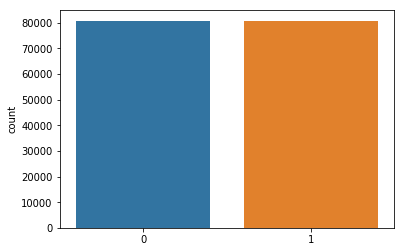

In [31]:
sns.countplot(y_resampled)

In [ ]:
## conv neural net

In [35]:
inputs = Input(shape=[300, 1])

conv = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
conv = MaxPool1D(pool_size=2)(conv)

conv = Conv1D(filters=128, kernel_size=3, activation='relu')(conv)
conv = MaxPool1D(pool_size=2)(conv)

conv = Conv1D(filters=256, kernel_size=3, activation='relu')(conv)
conv = MaxPool1D(pool_size=2)(conv)

# conv = Flatten()(conv)
conv = GlobalAveragePooling1D()(conv)

dense = Dense(64, activation='relu')(conv)
dense = Dense(32, activation='relu')(dense)
dense = Dense(1, activation='sigmoid')(dense)

nn_conv = Model(inputs=inputs, outputs=dense)
nn_conv.summary()

nn_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='sgd')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 298, 64)           256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 149, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 147, 128)          24704     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 73, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 71, 256)           98560     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 35, 256)           0         
__________

In [36]:
performance = nn_conv.fit(X_train, y_train, 
                          batch_size=64, epochs=10, 
                          validation_data=[X_test, y_test])

Train on 129296 samples, validate on 32324 samples
Epoch 1/10
129296/129296 [==============================] - 64s - loss: 0.6930 - acc: 0.5099 - val_loss: 0.6929 - val_acc: 0.4983